# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys
import sklearn.preprocessing
import sklearn.metrics

from implicit.als import AlternatingLeastSquares
from pandas.tseries.offsets import MonthEnd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise import NormalPredictor
from sklearn.metrics.pairwise import cosine_similarity

/home/mle-user/mle_projects/mle-recsys-project-start/.venv_recsys_start/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [3]:
tracks = pd.read_parquet("./recsys/initial/tracks.parquet")
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [23]:
catalog_names = pd.read_parquet("./recsys/initial/catalog_names.parquet")
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [5]:
interactions = pd.read_parquet("./recsys/initial/interactions.parquet")
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [ ]:
tracks.sample(3).T

,450709,919199,421158
track_id,31449434,78730658,29012877
albums,[3811673],"[14170710, 14875848]","[3101085, 3570647, 4037637]"
artists,"[28081, 289303, 418858, 1185435, 21074]",[7584055],[665555]
genres,"[23, 69]","[44, 75]","[47, 154]"


In [7]:
tracks['track_id'].nunique()

1000000

In [8]:
catalog_names.sample(3).T

,1188876,1396750,86279
id,25341599,40324363,852950
type,track,track,album
name,Wait a Minute,Rivers,The Green Knight


In [9]:
catalog_names['id'].nunique()

1776697

In [10]:
catalog_names['type'].value_counts()

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

In [11]:
interactions.sample(3).T

,138,437,967
user_id,1119771,50003,342444
track_id,813824,36549002,57678817
track_seq,139,438,968
started_at,2022-10-13 00:00:00,2022-06-07 00:00:00,2022-08-24 00:00:00


In [12]:
interactions['user_id'].value_counts()

user_id
398979     16637
1200889    15392
590868     15136
731216     13223
339714     12768
           ...  
653874         1
108229         1
1019304        1
357048         1
73645          1
Name: count, Length: 1373221, dtype: int64

In [13]:
interactions["started_at"].dt.to_period('M').value_counts()

started_at
2022-11    33968803
2022-10    31810464
2022-12    31043735
2022-09    26953965
2022-08    23919641
2022-07    20188819
2022-06    16266558
2022-05    13613489
2022-04    10230295
2022-03     7691225
2022-02     4533363
2022-01     2409541
Freq: M, Name: count, dtype: int64

In [14]:
interactions["started_at"].dt.to_period('Y').value_counts()

started_at
2022    222629898
Freq: A-DEC, Name: count, dtype: int64

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

1. Необходимо удалить пользователей с 5 или меньше событиями  
2. Для сокращения размера лучше оставить информацию за последние 2 месяца
3. Необходимо объединить информацию о треках с треками

In [15]:
interactions = interactions[interactions.groupby(['user_id']).transform('size') > 5]
interactions['user_id'].value_counts()

user_id
398979     16637
1200889    15392
590868     15136
731216     13223
339714     12768
           ...  
529972         6
529309         6
529278         6
620598         6
1294847        6
Name: count, Length: 1369604, dtype: int64

In [16]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222619423 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [5]:
event_cutoff_date = pd.to_datetime("2022-11-01").date()
interactions = interactions.query("started_at > @event_cutoff_date").copy()

started_at
2022-11-29    1161758
2022-12-02    1160274
2022-11-30    1159862
2022-11-26    1159535
2022-11-28    1159298
2022-11-27    1159198
2022-12-01    1159080
2022-11-25    1158614
2022-12-03    1158321
2022-12-05    1157985
2022-12-04    1156641
2022-12-06    1156024
2022-11-24    1154325
2022-11-23    1154243
2022-12-07    1152889
2022-11-22    1152451
2022-11-21    1149460
2022-11-20    1148081
2022-12-08    1147064
2022-12-09    1144840
2022-11-19    1144539
2022-11-18    1142929
2022-12-10    1140791
2022-11-17    1140079
2022-11-16    1137321
2022-12-11    1134918
2022-11-15    1133628
2022-11-13    1132112
2022-11-14    1130726
2022-12-12    1130650
2022-11-12    1125388
2022-12-13    1123510
2022-11-11    1122074
2022-11-10    1120140
2022-11-09    1117155
2022-12-14    1115321
2022-11-08    1113008
2022-11-07    1109874
2022-11-06    1106806
2022-12-15    1105811
2022-11-05    1103162
2022-11-04    1099154
2022-12-16    1095536
2022-11-03    1093110
2022-11-02    1090226

In [6]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63918740 entries, 31 to 291
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user_id     int32  
 1   track_id    int32  
 2   track_seq   int16  
 3   started_at  object 
 4   rating      float64
dtypes: float64(1), int16(1), int32(2), object(1)
memory usage: 2.0+ GB


In [19]:
catalog_names['type'].value_counts()

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

In [72]:
track_names = catalog_names.loc[catalog_names['type'] == "track"]
track_names = track_names.drop(columns=["type"])
track_names.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 812471 to 1812470
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   id      1000000 non-null  int64 
 1   name    1000000 non-null  object
dtypes: int64(1), object(1)
memory usage: 22.9+ MB


In [8]:
album_names = catalog_names.loc[catalog_names['type'] == "album"]
album_names = album_names.drop(columns=["type"])
album_names = album_names.rename(columns={"name": "album_name"})
album_names.info()

<class 'pandas.core.frame.DataFrame'>
Index: 658724 entries, 0 to 658723
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          658724 non-null  int64 
 1   album_name  658724 non-null  object
dtypes: int64(1), object(1)
memory usage: 15.1+ MB


In [76]:
album_names['id'].nunique()

658724

In [30]:
artist_names = catalog_names.loc[catalog_names['type'] == "artist"]
artist_names = artist_names.drop(columns=["type"])
artist_names = artist_names.rename(columns={"name": "artist_name"})
artist_names.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153581 entries, 658724 to 812304
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           153581 non-null  int64 
 1   artist_name  153581 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


In [24]:
genre_names = catalog_names.loc[catalog_names['type'] == "genre"]
genre_names = genre_names.drop(columns=["type"])
genre_names = genre_names.rename(columns={"name": "genre_name"})
genre_names.info()

<class 'pandas.core.frame.DataFrame'>
Index: 166 entries, 812305 to 812470
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          166 non-null    int64 
 1   genre_name  166 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.9+ KB


In [24]:
tracks = tracks.merge(track_names, left_on='track_id', right_on='id')
tracks.head()

,track_id,albums,artists,genres,id,name
0,26,"[3, 2490753]",[16],"[11, 21]",26,Complimentary Me
1,38,"[3, 2490753]",[16],"[11, 21]",38,Momma's Boy
2,135,"[12, 214, 2490809]",[84],[11],135,Atticus
3,136,"[12, 214, 2490809]",[84],[11],136,24 Hours
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],138,Don't Upset The Rhythm (Go Baby Go)


In [25]:
genre_names = genre_names.set_index("id")

In [26]:
tracks['genre_names'] = np.NAN

In [27]:
gnr = genre_names.T.to_dict('list')
gnr

{0: ['all'],
 1: ['eastern'],
 2: ['rusrock'],
 3: ['rusrap'],
 4: ['postrock'],
 5: ['ukrrock'],
 6: ['local-indie'],
 7: ['rusbards'],
 8: ['romances'],
 9: ['videogame'],
 10: ['tatar'],
 11: ['pop'],
 12: ['shanson'],
 13: ['alternative'],
 14: ['rock'],
 15: ['tvseries'],
 16: ['dance'],
 17: ['films'],
 18: ['animated'],
 19: ['rusestrada'],
 20: ['ruspop'],
 21: ['folk'],
 22: ['caucasian'],
 23: ['classical'],
 24: ['fairytales'],
 25: ['soundtrack'],
 26: ['soul'],
 27: ['spiritual'],
 28: ['jazz'],
 29: ['naturesounds'],
 30: ['asmr'],
 31: ['children'],
 32: ['forchildren'],
 33: ['blues'],
 34: ['caribbean'],
 35: ['country'],
 36: ['classic'],
 37: ['disco'],
 38: ['classicmetal'],
 39: ['funk'],
 40: ['progmetal'],
 41: ['numetal'],
 42: ['holiday'],
 43: ['epicmetal'],
 44: ['foreignrap'],
 45: ['folkmetal'],
 46: ['latin'],
 47: ['metal'],
 48: ['musical'],
 49: ['newage'],
 50: ['punk'],
 51: ['reggae'],
 52: ['extrememetal'],
 53: ['spoken'],
 54: ['posthardcore'],
 5

In [28]:
for k,item in tracks['genres'].items():
    arr = []
    for i in range(len(item)):
        if item[i] in gnr.keys():
            arr.append(gnr[item[i]][0])
    tracks['genre_names'][k] = arr        

/tmp/ipykernel_1771/936772188.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['genre_names'][k] = arr
/tmp/ipykernel_1771/936772188.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['pop', 'folk']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tracks['genre_names'][k] = arr


In [29]:
tracks.head(5)

,track_id,albums,artists,genres,id,name,genre_names
0,26,"[3, 2490753]",[16],"[11, 21]",26,Complimentary Me,"[pop, folk]"
1,38,"[3, 2490753]",[16],"[11, 21]",38,Momma's Boy,"[pop, folk]"
2,135,"[12, 214, 2490809]",[84],[11],135,Atticus,[pop]
3,136,"[12, 214, 2490809]",[84],[11],136,24 Hours,[pop]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],138,Don't Upset The Rhythm (Go Baby Go),[pop]


In [49]:
artist_names = artist_names.set_index("id")

In [31]:
artists = artist_names.T.to_dict('list')
artists

{4: ['Kenny Dorham'],
 5: ['Max Roach'],
 7: ['Francis Rossi'],
 9: ['Status Quo'],
 12: ['Phil Everly'],
 14: ['Carole King'],
 15: ['Sharon Robinson'],
 16: ['Elizabeth & the Catapult'],
 22: ['Leonard Cohen'],
 31: ['Count Basie'],
 33: ['John Coltrane'],
 34: ['Miles Davis'],
 36: ['Baker'],
 42: ['Народное'],
 80: ['Dan Smith'],
 84: ['Noisettes'],
 86: ['Daniel Smith'],
 87: ['Michael Schenker'],
 90: ['Scorpions'],
 92: ['Rudolf Schenker'],
 93: ['Femi Kuti'],
 94: ['Brett Dennen'],
 98: ['Traditional'],
 119: ['Stanley Brothers'],
 126: ['The Fourmost'],
 136: ['Little Alice'],
 171: ['сборник'],
 176: ['Four Tops'],
 180: ['Hugh Cornwell'],
 182: ['Douglas Gamley'],
 183: ['Simple Minds'],
 184: ['Jim Kerr'],
 187: ['Siouxsie Sioux'],
 188: ['Neil Young'],
 195: ['Nick Lowe'],
 211: ['The Dramatics'],
 216: ['Gato Barbieri'],
 218: ['Stunt'],
 220: ['Binary Finary'],
 223: ['Terri Lyne Carrington'],
 226: ['Teena Marie'],
 228: ['Paul Desmond'],
 230: ['Gerry Mulligan'],
 241:

In [50]:
artist_names.head()

,artist_name
id,
4,Kenny Dorham
5,Max Roach
7,Francis Rossi
9,Status Quo
12,Phil Everly


In [55]:
tracks['artist_names'] = np.NAN
for k,item in tracks['artists'].items():
    arr = []
    for i in range(len(item)):
        for k_a, i_a in artist_names.items():
            if item[i] in i_a.keys():
                arr.append(i_a[item[i]])
    tracks['artist_names'][k] = arr 

/tmp/ipykernel_1724/3293130573.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['artist_names'][k] = arr
/tmp/ipykernel_1724/3293130573.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Elizabeth & the Catapult']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tracks['artist_names'][k] = arr


In [57]:
tracks.head()

,track_id,albums,artists,genres,id,name,genre_names,artist_names
0,26,"[3, 2490753]",[16],"[11, 21]",26,Complimentary Me,"[pop, folk]",[Elizabeth & the Catapult]
1,38,"[3, 2490753]",[16],"[11, 21]",38,Momma's Boy,"[pop, folk]",[Elizabeth & the Catapult]
2,135,"[12, 214, 2490809]",[84],[11],135,Atticus,[pop],[Noisettes]
3,136,"[12, 214, 2490809]",[84],[11],136,24 Hours,[pop],[Noisettes]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],138,Don't Upset The Rhythm (Go Baby Go),[pop],[Noisettes]


In [9]:
album_names = album_names.set_index("id")

In [10]:
tracks['album_names'] = np.NAN
for k,item in tracks['albums'].items():
    arr = []
    for i in range(len(item)):
        for k_a, i_a in album_names.items():
            if item[i] in i_a.keys():
                arr.append(i_a[item[i]])
    tracks['album_names'][k] = arr 

/tmp/ipykernel_26751/562614863.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['album_names'][k] = arr
/tmp/ipykernel_26751/562614863.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Taller Children', 'Taller Children']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tracks['album_names'][k] = arr


In [35]:
tracks.head(5)

,track_id,albums,artists,genres,name,genre_names,artist_names,album_names,popularity
0,26,"[3, 2490753]",[16],"[11, 21]",Complimentary Me,"[pop, folk]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]",0.0
1,38,"[3, 2490753]",[16],"[11, 21]",Momma's Boy,"[pop, folk]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]",0.0
2,135,"[12, 214, 2490809]",[84],[11],Atticus,[pop],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",0.0
3,136,"[12, 214, 2490809]",[84],[11],24 Hours,[pop],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",0.0
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),[pop],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Don't U...",2.0


In [34]:
tracks = tracks.drop(columns=["id"])

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [7]:
s1 = interactions \
    .groupby(["track_id"]).agg(popularity=("user_id", "nunique"))

In [8]:
s1.sort_values(by="popularity",ascending=False).head(10)

,popularity
track_id,
83063895,45841
93126179,45334
81848875,44788
84382282,44403
65851540,42314
60292250,42063
78426489,41917
76434671,37228
75944934,36849


In [14]:
tracks = tracks.merge(s1, how='left', on=['track_id'])

In [15]:
tracks['popularity'] = tracks['popularity'].fillna(0)

In [16]:
tracks.head()

,track_id,albums,artists,genres,name,genre_names,artist_names,album_names,popularity
0,26,"[3, 2490753]",[16],"[11, 21]",Complimentary Me,"[pop, folk]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]",0.0
1,38,"[3, 2490753]",[16],"[11, 21]",Momma's Boy,"[pop, folk]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]",0.0
2,135,"[12, 214, 2490809]",[84],[11],Atticus,[pop],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",0.0
3,136,"[12, 214, 2490809]",[84],[11],24 Hours,[pop],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",0.0
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),[pop],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Don't U...",0.0


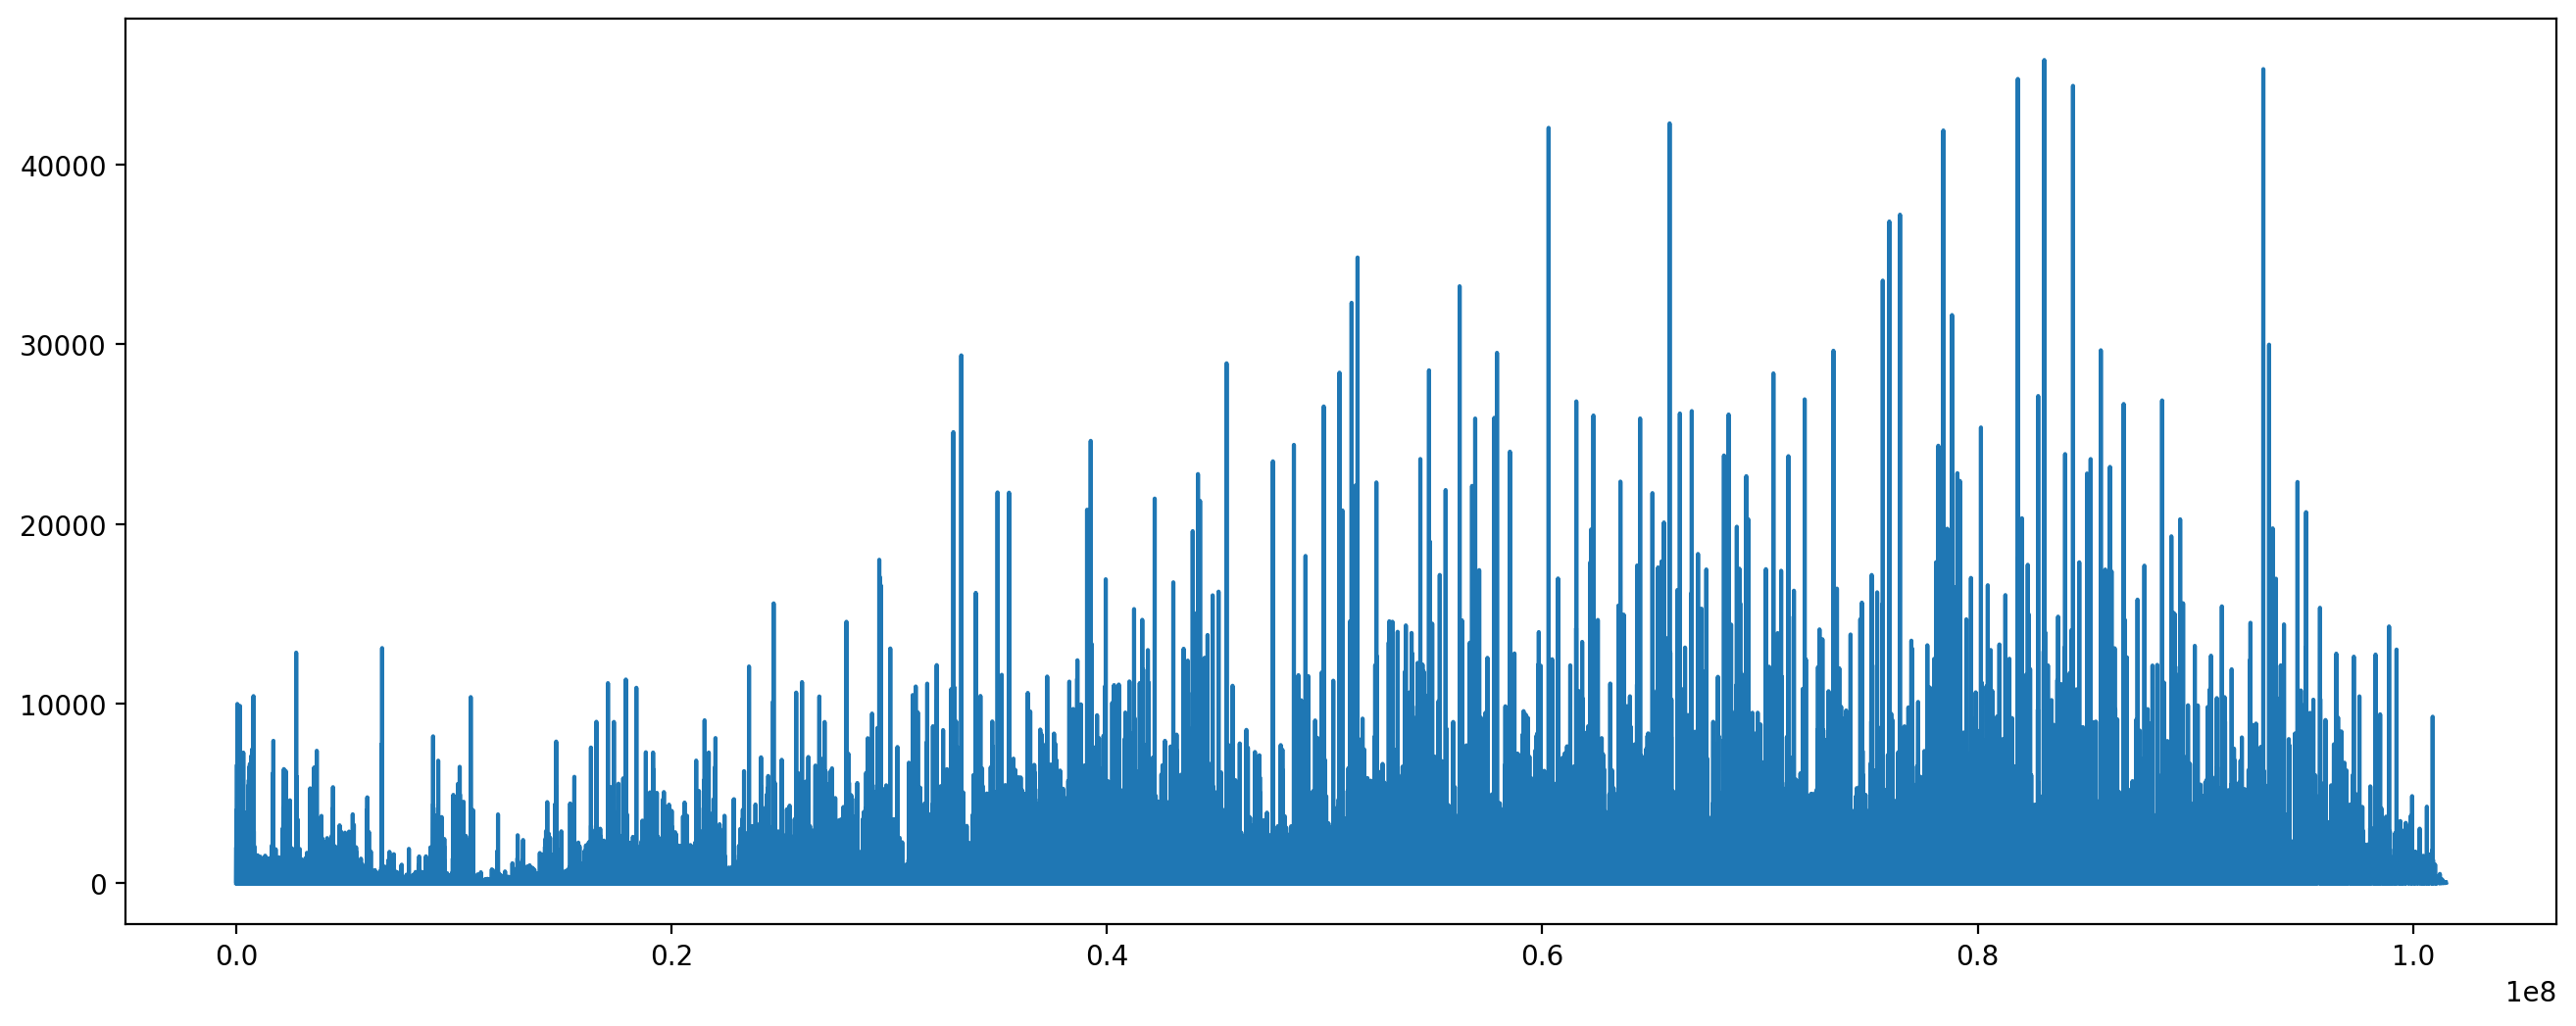

In [17]:
plt.subplots(figsize=(16, 6))
plt.plot(tracks['track_id'], tracks['popularity'])

Наиболее популярные треки

In [19]:
tracks.sort_values(by="popularity",ascending=False).head()

,track_id,albums,artists,genres,name,genre_names,artist_names,album_names,popularity
940964,83063895,[15598104],[5129397],"[11, 20]",Птичка,"[pop, ruspop]",[HammAli & Navai],[Птичка],45841.0
980395,93126179,[18729695],[4664209],"[11, 20]",Солнце Монако,"[pop, ruspop]",[Люся Чеботина],[The End],45334.0
935913,81848875,[15213275],[10318860],"[11, 20]",Федерико Феллини,"[pop, ruspop]",[Galibri & Mavik],[Федерико Феллини],44788.0
946020,84382282,[15985737],"[5056591, 2938031]","[3, 75]",Я в моменте,"[rusrap, rap]","[Джарахов, Markul]",[Я в моменте],44403.0
829320,65851540,[10692414],[1554548],"[11, 20]",Юность,"[pop, ruspop]",[Dabro],[Юность],42314.0


Наиболее популярные жанры

In [20]:
genre_pop = {}
    
    
for k,item in tracks['genres'].items():
    for i in range(len(item)):
        if item[i] in genre_pop.keys():
            genre_pop[item[i]] += tracks['popularity'][item[i]]
        else:
            genre_pop[item[i]] = tracks['popularity'][item[i]]


In [21]:
genre_pop

{11: 498855.0,
 21: 0.0,
 59: 0.0,
 102: 11969409.0,
 14: 55177.0,
 33: 105084.0,
 38: 0.0,
 47: 72311.0,
 13: 128706.0,
 28: 319152.0,
 164: 0.0,
 68: 0.0,
 74: 0.0,
 162: 25974.0,
 70: 0.0,
 16: 0.0,
 35: 5170.0,
 138: 0.0,
 26: 0.0,
 39: 9646.0,
 335: 63723.0,
 75: 5128480.0,
 44: 0.0,
 163: 5351.0,
 325: 0.0,
 308: 77572.0,
 27: 2986.0,
 69: 0.0,
 73: 1689.0,
 51: 5575.0,
 25: 82508.0,
 45: 607664.0,
 159: 8348.0,
 101: 129681.0,
 49: 169026.0,
 128: 0.0,
 17: 0.0,
 923: 0.0,
 151: 77901.0,
 157: 3994.0,
 50: 1128816.0,
 319: 9048.0,
 415: 99505.0,
 37: 0.0,
 41: 375669.0,
 169: 86180.0,
 56: 62154.0,
 55: 110520.0,
 112: 0.0,
 53: 141918.0,
 43: 0.0,
 1016: 0.0,
 23: 0.0,
 15: 0.0,
 153: 0.0,
 161: 0.0,
 246: 2949.0,
 703: 15402.0,
 117: 3312.0,
 89: 29040.0,
 127: 0.0,
 54: 2659230.0,
 58: 909.0,
 9: 10528.0,
 158: 223882.0,
 48: 1878.0,
 167: 0.0,
 383: 1214.0,
 743: 7038.0,
 18: 0.0,
 155: 0.0,
 1197: 0.0,
 165: 5726.0,
 227: 0.0,
 1182: 454.0,
 20: 46707.0,
 154: 8170.0,
 63: 

In [22]:
genre_popularity = pd.DataFrame.from_dict(genre_pop, orient='index')
genre_popularity

,0
11,498855.0
21,0.0
59,0.0
102,11969409.0
14,55177.0
...,...
105,2670.0
108,15708.0
107,2480.0
106,60.0


In [25]:
genre_popularity = genre_popularity.reset_index()
genre_popularity

,id,0
0,11,498855.0
1,21,0.0
2,59,0.0
3,102,11969409.0
4,14,55177.0
...,...,...
168,105,2670.0
169,108,15708.0
170,107,2480.0
171,106,60.0


In [26]:
genre_popularity = genre_popularity.merge(genre_names, how="right", on="id")
genre_popularity

,id,0,genre_name
0,0,NaN,all
1,1,0.0,eastern
2,2,0.0,rusrock
3,3,0.0,rusrap
4,4,0.0,postrock
...,...,...,...
161,1182,454.0,balkan
162,1197,0.0,experimental
163,1370,NaN,europop
164,1484,1606.0,meditation


In [27]:
genre_popularity = genre_popularity.rename(columns={0:"genre_popularity"})
genre_popularity["genre_popularity"] = genre_popularity["genre_popularity"].fillna(0)
genre_popularity.head()

,id,genre_popularity,genre_name
0,0,0.0,all
1,1,0.0,eastern
2,2,0.0,rusrock
3,3,0.0,rusrap
4,4,0.0,postrock


In [28]:
genre_popularity.sort_values(by='genre_popularity',ascending=False)

,id,genre_popularity,genre_name
102,102,11969409.0,allrock
75,75,5128480.0,rap
54,54,2659230.0,posthardcore
77,77,1181875.0,education
50,50,1128816.0,punk
...,...,...,...
72,72,0.0,business
71,71,0.0,arts
70,70,0.0,indie
69,69,0.0,classicalmusic


Треки, которые никто не прослушал

In [29]:
not_list = tracks[~tracks['track_id'].isin(interactions['track_id'])]
not_list

,track_id,albums,artists,genres,name,genre_names,artist_names,album_names,popularity
0,26,"[3, 2490753]",[16],"[11, 21]",Complimentary Me,"[pop, folk]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]",0.0
1,38,"[3, 2490753]",[16],"[11, 21]",Momma's Boy,"[pop, folk]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]",0.0
2,135,"[12, 214, 2490809]",[84],[11],Atticus,[pop],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",0.0
3,136,"[12, 214, 2490809]",[84],[11],24 Hours,[pop],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",0.0
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),[pop],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Don't U...",0.0
...,...,...,...,...,...,...,...,...,...
957865,87341742,[16871204],[12541816],"[11, 20]",Гроза и муза,"[pop, ruspop]",[Zina Bless],[Гроза и муза],0.0
958226,87434758,[11781223],[],"[62, 72, 77]",Как развивать самодисциплину и личный бренд • ...,"[podcasts, business, education]",[],[Потом доделаю],0.0
958675,87543206,[16934920],[11873213],[47],Gospel,[metal],[LongestSoloEver],[Gospel],0.0
966001,89472205,[17552246],[11861149],"[11, 20]",Когда Ты Рядом,"[pop, ruspop]",[Bolin & Almarie],[Когда Ты Рядом],0.0


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [ ]:
interactions['started_at'] = interactions['started_at'].dt.date
interactions.head()

In [31]:
interactions['rating'] = interactions.groupby("user_id")['track_seq'].rank(method='dense', ascending=False)
interactions.head()

,user_id,track_id,track_seq,started_at,rating
31,3,68348391,32,2022-12-14,2.0
32,3,78194999,33,2022-12-20,1.0
197,4,59535907,198,2022-11-03,59.0
198,4,60102026,199,2022-11-03,58.0
199,4,61424101,200,2022-11-03,57.0


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [32]:
tracks.to_parquet("./recsys/data/items.parquet")
interactions.to_parquet("./recsys/data/events.parquet")
genre_popularity.to_parquet("./recsys/data/genre_popularity.parquet")

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [3]:
items = pd.read_parquet("./recsys/data/items.parquet")
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   track_id      1000000 non-null  int64  
 1   albums        1000000 non-null  object 
 2   artists       1000000 non-null  object 
 3   genres        1000000 non-null  object 
 4   name          1000000 non-null  object 
 5   genre_names   1000000 non-null  object 
 6   artist_names  1000000 non-null  object 
 7   album_names   1000000 non-null  object 
 8   popularity    1000000 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 68.7+ MB


In [4]:
events = pd.read_parquet("./recsys/data/events.parquet")
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63918740 entries, 31 to 291
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user_id     int32  
 1   track_id    int32  
 2   track_seq   int16  
 3   started_at  object 
 4   rating      float64
dtypes: float64(1), int16(1), int32(2), object(1)
memory usage: 2.0+ GB


In [5]:
genre_popularity = pd.read_parquet("./recsys/data/genre_popularity.parquet")
genre_popularity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                166 non-null    int64  
 1   genre_popularity  166 non-null    float64
 2   genre_name        166 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 4.0+ KB


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [6]:
train_test_global_time_split_date = pd.to_datetime("2022-12-16").date()
train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date

events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

common_users = list(set(users_train) & set(users_test))
print(len(users_train), len(users_test), len(common_users)) 

1140855 781881 743264


In [7]:
cold_users = list(set(users_test) - set(common_users))
print(len(cold_users)) 

38617


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [8]:
items['score'] = (items['popularity']/items['popularity'].sum())*1000
items.sort_values(by="score",ascending=False).head(5) 

,track_id,albums,artists,genres,name,genre_names,artist_names,album_names,popularity,score
940964,83063895,[15598104],[5129397],"[11, 20]",Птичка,"[pop, ruspop]",[HammAli & Navai],[Птичка],45841.0,0.717176
980395,93126179,[18729695],[4664209],"[11, 20]",Солнце Монако,"[pop, ruspop]",[Люся Чеботина],[The End],45334.0,0.709244
935913,81848875,[15213275],[10318860],"[11, 20]",Федерико Феллини,"[pop, ruspop]",[Galibri & Mavik],[Федерико Феллини],44788.0,0.700702
946020,84382282,[15985737],"[5056591, 2938031]","[3, 75]",Я в моменте,"[rusrap, rap]","[Джарахов, Markul]",[Я в моменте],44403.0,0.694679
829320,65851540,[10692414],[1554548],"[11, 20]",Юность,"[pop, ruspop]",[Dabro],[Юность],42314.0,0.661997


In [9]:
top_popular = items.sort_values(by="score",ascending=False).head(100).reset_index(drop=True)
top_popular.head(5) 

,track_id,albums,artists,genres,name,genre_names,artist_names,album_names,popularity,score
0,83063895,[15598104],[5129397],"[11, 20]",Птичка,"[pop, ruspop]",[HammAli & Navai],[Птичка],45841.0,0.717176
1,93126179,[18729695],[4664209],"[11, 20]",Солнце Монако,"[pop, ruspop]",[Люся Чеботина],[The End],45334.0,0.709244
2,81848875,[15213275],[10318860],"[11, 20]",Федерико Феллини,"[pop, ruspop]",[Galibri & Mavik],[Федерико Феллини],44788.0,0.700702
3,84382282,[15985737],"[5056591, 2938031]","[3, 75]",Я в моменте,"[rusrap, rap]","[Джарахов, Markul]",[Я в моменте],44403.0,0.694679
4,65851540,[10692414],[1554548],"[11, 20]",Юность,"[pop, ruspop]",[Dabro],[Юность],42314.0,0.661997


In [10]:
top_popular.to_parquet("./recsys/recommendations/top_popular.parquet")

# Персональные

Рассчитаем персональные рекомендации.

In [26]:
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["track_id"])
items["track_id_enc"] = item_encoder.transform(items["track_id"])
events_train["track_id_enc"] = item_encoder.transform(events_train["track_id"])
events_test["track_id_enc"] = item_encoder.transform(events_test["track_id"])

/tmp/ipykernel_2834/429475662.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
/tmp/ipykernel_2834/429475662.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
/tmp/ipykernel_2834/429475662.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [27]:
events_train.head()

,user_id,track_id,track_seq,started_at,rating,user_id_enc,item_id_enc,track_id_enc
31,3,68348391,32,2022-12-14,2.0,0,848375,848375
197,4,59535907,198,2022-11-03,59.0,1,772727,772727
198,4,60102026,199,2022-11-03,58.0,1,777786,777786
199,4,61424101,200,2022-11-03,57.0,1,789238,789238
200,4,61619676,201,2022-11-05,56.0,1,790871,790871


In [13]:
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["rating"],
    (events_train['user_id_enc'], events_train['track_id_enc'])),
    dtype=np.int8)

In [14]:
als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train) 

/home/mle-user/mle_projects/mle-recsys-project-start/.venv_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 50/50 [13:16<00:00, 15.93s/it]


In [16]:
user_ids_encoded = range(len(user_encoder.classes_))

als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=50)

In [19]:
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "track_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["track_id_enc", "score"], ignore_index=True)

als_recommendations["track_id_enc"] = als_recommendations["track_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["track_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "track_id_enc"])

KeyError: 0

In [20]:
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.head(5)

,user_id,item_id,score
0,3,68348390,0.009621
1,3,68348389,0.009436
2,3,68348391,0.008584
3,3,68878561,0.007992
4,3,68070362,0.007861


In [22]:
als_recommendations = als_recommendations.rename(columns = {"item_id":"track_id"})
als_recommendations.head(5)

,user_id,track_id,score
0,3,68348390,0.009621
1,3,68348389,0.009436
2,3,68348391,0.008584
3,3,68878561,0.007992
4,3,68070362,0.007861


In [23]:
als_recommendations.to_parquet("./recsys/recommendations/personal_als.parquet")

In [25]:
events_train.head()

,user_id,track_id,track_seq,started_at,rating,user_id_enc,item_id_enc
31,3,68348391,32,2022-12-14,2.0,0,848375
197,4,59535907,198,2022-11-03,59.0,1,772727
198,4,60102026,199,2022-11-03,58.0,1,777786
199,4,61424101,200,2022-11-03,57.0,1,789238
200,4,61619676,201,2022-11-05,56.0,1,790871


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [29]:
train_item_ids_enc = events_train['track_id_enc'].unique()

max_similar_items = 10

similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "track_id_enc": train_item_ids_enc,
    "sim_track_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})
similar_items

,track_id_enc,sim_track_id_enc,score
0,848375,"[848375, 848371, 848368, 852166, 848374, 85216...","[1.0000001192092896, 0.9849179983139038, 0.979..."
1,772727,"[772727, 770130, 766091, 764538, 770574, 76415...","[1.0000001192092896, 0.9605469107627869, 0.957..."
2,777786,"[777786, 777407, 775103, 781162, 781163, 77642...","[0.9999998807907104, 0.9467445015907288, 0.937..."
3,789238,"[789238, 794288, 794287, 791275, 789107, 79721...","[1.0, 0.9599848985671997, 0.940486490726471, 0..."
4,790871,"[790871, 799353, 784120, 775631, 794781, 77644...","[1.0, 0.8718301057815552, 0.8694903254508972, ..."
...,...,...,...
895114,146080,"[146080, 146070, 125106, 125101, 125316, 15151...","[1.0000001192092896, 0.9929046034812927, 0.980..."
895115,183967,"[183967, 424500, 23154, 578547, 39801, 306146,...","[0.9999997615814209, 0.9998893141746521, 0.999..."
895116,588187,"[588187, 323348, 259854, 259855, 186209, 17171...","[1.0, 0.7668942213058472, 0.7566102743148804, ..."
895117,756515,"[756515, 547884, 277041, 116482, 220363, 44604...","[0.9999998807907104, 0.9884139895439148, 0.986..."


In [30]:
similar_items = similar_items.explode(["sim_track_id_enc", "score"], ignore_index=True)
similar_items.head()

,track_id_enc,sim_track_id_enc,score
0,848375,848375,1.0
1,848375,848371,0.984918
2,848375,848368,0.979388
3,848375,852166,0.976155
4,848375,848374,0.973634
...,...,...,...
9846304,199932,155495,0.956426
9846305,199932,199864,0.956123
9846306,199932,156007,0.955624
9846307,199932,188113,0.954457


In [31]:
similar_items["sim_track_id_enc"] = similar_items["sim_track_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")
similar_items.head()

,track_id_enc,sim_track_id_enc,score
0,848375,848375,1.000000
1,848375,848371,0.984918
2,848375,848368,0.979388
3,848375,852166,0.976155
4,848375,848374,0.973634


In [32]:
similar_items["track_id_1"] = item_encoder.inverse_transform(similar_items["track_id_enc"])
similar_items["track_id_2"] = item_encoder.inverse_transform(similar_items["sim_track_id_enc"])
similar_items = similar_items.drop(columns=["track_id_enc", "sim_track_id_enc"])

similar_items = similar_items.query("track_id_1 != track_id_2")
similar_items.head()

,score,track_id_1,track_id_2
1,0.984918,68348391,68348387
2,0.979388,68348391,68348384
3,0.976155,68348391,68878565
4,0.973634,68348391,68348390
5,0.972113,68348391,68878561


In [33]:
similar_items.to_parquet("./recsys/recommendations/similar.parquet")

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.